## Models and data

In [17]:
from UNetPyTorch import *

import xarray as xr
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from datetime import datetime

import cartopy
import cartopy.crs as ccrs

from torch.utils.data import DataLoader, Dataset

ds = xr.open_dataset('data_850/2022_850_SA_coarsen.nc')
ds.load()

<xarray.Dataset> Size: 197MB
Dimensions:    (time: 8760, latitude: 16, longitude: 32)
Coordinates:
  * time       (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T23:00:00
  * longitude  (longitude) float32 128B 16.31 16.81 17.31 ... 30.81 31.31 31.81
  * latitude   (latitude) float32 64B -34.89 -34.39 -33.89 ... -27.89 -27.39
Data variables:
    q          (time, latitude, longitude) float64 36MB 0.007599 ... 0.009553
    t          (time, latitude, longitude) float64 36MB 282.4 282.5 ... 284.3
    u          (time, latitude, longitude) float64 36MB 14.09 13.71 ... 3.188
    v          (time, latitude, longitude) float64 36MB -0.8432 -1.022 ... 4.144
    w          (time, latitude, longitude) float64 36MB -0.002005 ... 0.1457
    wspd       (time, latitude, longitude) float32 18MB 14.12 13.75 ... 5.228
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-28 12:36:03 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...
    wspd_units:   m/s

### Model

In [18]:
class build_res_unet(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        ''' Encoder 1 '''
        self.c11 = nn.Conv2d(in_c, 32, kernel_size=3, padding=1)
        self.br1 = batchnorm_relu(32)
        self.c12 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.c13 = nn.Conv2d(in_c, 32, kernel_size=1, padding=0) # Shortcut feature

        """ Encoder 2 and 3 """
        self.r2 = residual_block(32, 64, stride=2)
        self.r3 = residual_block(64, 128, stride=2)

        """ Bridge """
        self.r4 = residual_block(128, 256, stride=2)

        """ Decoder """
        self.d1 = decoder_block(256, 128)
        self.d2 = decoder_block(128, 64)
        self.d3 = decoder_block(64, 32)

        """ Output """
        self.output = nn.Conv2d(32, out_c, kernel_size=1, padding=0)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        """ Encoder 1 """
        x = self.c11(inputs)
        x = self.br1(x)
        x = self.c12(x)
        s = self.c13(inputs)
        skip1 = x + s

        """ Encoder 2 and 3 """
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)

        """ Bridge """
        b = self.r4(skip3)

        """ Decoder """
        d1 = self.d1(b, skip3)
        d2 = self.d2(d1, skip2)
        d3 = self.d3(d2, skip1)

        """ output """
        output = self.output(d3)
        # output = self.sigmoid(output)

        return output

class build_res_unet_time(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        ''' Encoder 1 '''
        self.c11 = nn.Conv2d(in_c + 2, 64, kernel_size=3, padding=1)  # in_c + 2 to account for time inputs
        self.br1 = batchnorm_relu(64)
        self.c12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.c13 = nn.Conv2d(in_c + 2, 64, kernel_size=1, padding=0)  # Shortcut feature

        """ Encoder 2 and 3 """
        self.r2 = residual_block(64, 128, stride=2)
        self.r3 = residual_block(128, 256, stride=2)

        """ Bridge """
        self.r4 = residual_block(256, 512, stride=2)

        """ Decoder """
        self.d1 = decoder_block(512, 256)
        self.d2 = decoder_block(256, 128)
        self.d3 = decoder_block(128, 64)

        """ Output """
        self.output = nn.Conv2d(64, out_c, kernel_size=1, padding=0)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, weather_data, time_input):
        # weather_data shape: (batch_size, window_size, lat, lon)
        # time_input shape: (batch_size, window_size, 2) where 2 corresponds to (hour of day, month of year)

        batch_size, window_size, lat, lon = weather_data.shape

        # Reshape weather_data to (batch_size, window_size, 1, lat, lon)
        weather_data = weather_data.view(batch_size, 1, lat, lon)

        # Expand time_input to match the spatial dimensions of the weather data
        time_input = time_input.view(batch_size, window_size, 2)  # (batch_size, window_size, 2)

        # Expand to match spatial dimensions (lat, lon) and channel 2 for (hour, month)
        time_input_expanded = time_input.unsqueeze(-1).unsqueeze(-1)  # Add spatial dimensions
        time_input_expanded = time_input_expanded.expand(-1, -1, lat, lon)  # Now shape is (batch_size, 2, lat, lon)

        # Concatenate along the channel axis
        combined_input = torch.cat([weather_data, time_input_expanded], dim=1)  # New shape: (batch_size, in_c + 2, lat, lon)

        """ Encoder 1 """
        x = self.c11(combined_input)
        x = self.br1(x)
        x = self.c12(x)
        s = self.c13(combined_input)
        skip1 = x + s

        """ Encoder 2 and 3 """
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)

        """ Bridge """
        b = self.r4(skip3)

        """ Decoder """
        d1 = self.d1(b, skip3)
        d2 = self.d2(d1, skip2)
        d3 = self.d3(d2, skip1)

        """ Output """
        output = self.output(d3)
        # output = self.sigmoid(output)

        return output


class WeatherData(Dataset):
    def __init__(self, dataset: xr.Dataset, window_size: int = 24, steps: int = 3, auto = False):
        self.dataset = dataset
        self.window_size = window_size
        self.steps = steps
        self.calculate_wind_speed()
        self.dataset = self.dataset.sortby('latitude')

        self.min_value = self.dataset.wspd.min().item()
        self.max_value = self.dataset.wspd.max().item()

        self.mean_value = self.dataset.wspd.mean().item()
        self.std_value = self.dataset.wspd.std().item()
        

        if auto:
            self.window_dataset()
            self.split_data()    
            self.normalize_data()    

    def __len__(self):
        return len(self.X_train)
    
    def __getitem__(self, idx):
        return self.X_train_t[idx], self.F_train[idx], self.y_train_t[idx, 0].reshape(1, self.dataset.sizes['latitude'], self.dataset.sizes['longitude'])
    
    def subset_data(self, coarsen = 1):
        if coarsen > 1:
            lat_slice = slice(1, 33, coarsen)
            lon_slice = slice(3, 67, coarsen)
        else:
            lat_slice = slice(1, 33)  
            lon_slice = slice(3, 67)

        self.dataset = self.dataset.isel(latitude=lat_slice, longitude=lon_slice)

    def calculate_wind_speed(self):
        self.dataset['wspd'] = np.sqrt(self.dataset.u**2 + self.dataset.v**2).astype(np.float32)
        self.dataset.attrs['wspd_units'] = 'm/s'
        # self.dataset['wdir'] = np.arctan2(self.dataset.v, self.dataset.u) * 180 / np.pi
        # self.dataset.attrs['wdir_units'] = 'degrees'

    def window_dataset(self, variable: str = 'wspd'):
        time_dim = self.dataset.sizes['time']
        total_windows = time_dim - self.window_size - self.steps

        # Preallocate arrays for better performance
        features = np.empty((total_windows, self.window_size, self.dataset.sizes['latitude'], self.dataset.sizes['longitude']), dtype=np.float32)
        targets = np.empty((total_windows,  self.steps, self.dataset.sizes['latitude'], self.dataset.sizes['longitude']), dtype=np.float32)
        forcings = np.empty((total_windows, 2), dtype=np.int32)
        time_values = np.empty((total_windows, self.window_size), dtype='datetime64[ns]')

        # Slice the dataset for all the time values at once
        dataset_time = self.dataset.time.values
        dataset_hour = self.dataset.time.dt.hour.values
        dataset_month = self.dataset.time.dt.month.values

        # Vectorized slicing
        for i in range(total_windows):
            print(f'{i}/{total_windows}', end='\r')
            
            # Slice features, targets, time values, and forcings in batches
            features[i] = self.dataset[variable].isel(time=slice(i, i + self.window_size)).values
            targets[i] = self.dataset[variable].isel(time=slice(i + self.window_size, i + self.window_size + self.steps)).values
            time_values[i] = dataset_time[i:i + self.window_size]

            # Hour and month forcings
            forcings[i] = [dataset_hour[i + self.window_size], dataset_month[i + self.window_size]]

        # Save arrays as attributes
        self.features = features
        self.targets = targets
        self.forcings = forcings
        self.time_values = time_values

        print('Windowed...')

    def split_data(self, test_size=0.2, random_state=42):
        """
        Splits the data into training, validation, and test sets.
        """

        print('Splitting...')
        self.X_train, self.X_test, self.y_train, self.y_test, self.F_train, self.F_test, self.T_train, self.T_test = train_test_split(
            self.features, self.targets, self.forcings, self.time_values,
            test_size= test_size)
     
        print('Shuffling...')
        
        self.X_train, self.y_train, self.F_train, self.T_train = shuffle(self.X_train, self.y_train, self.F_train, self.T_train, random_state=random_state)

    def normalize_data(self):
        # Normalize the data with standard deviation
        self.X_train_t = (self.X_train - self.mean_value) / self.std_value
        self.y_train_t = (self.y_train - self.mean_value) / self.std_value

        self.X_test_t = (self.X_test - self.mean_value) / self.std_value
        self.y_test_t = (self.y_test - self.mean_value) / self.std_value

        # To tensors
        self.X_train_t = torch.tensor(self.X_train_t).float()
        self.y_train_t = torch.tensor(self.y_train_t).float()
        
        self.X_test_t = torch.tensor(self.X_test_t).float()
        self.y_test_t = torch.tensor(self.y_test_t).float()

    def plot_from_ds(self, seed = 0, frame_rate=16, levels =10):
        bounds = [self.dataset.longitude.min().item(), self.dataset.longitude.max().item(), self.dataset.latitude.min().item(), self.dataset.latitude.max().item()]
        features = self.features[seed]
        targets = self.targets[seed]
        time_values = self.time_values

        features = features * (self.max_value - self.min_value) + self.min_value
        targets = targets * (self.max_value - self.min_value) + self.min_value

        fig, axs = plt.subplots(1, 2, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

        vmin = min(features.min().item(), targets.min().item())
        vmax = max(features.max().item(), targets.max().item())

        fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2)

        for ax in axs:
            ax.set_extent(bounds, crs=ccrs.PlateCarree())
            ax.coastlines()


        feat = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        tar = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        axs[1].set_title('Target')

        fig.colorbar(feat, ax=axs[0], orientation='vertical', label='Wind Speed (m/s)')
        fig.colorbar(tar, ax=axs[1], orientation='vertical', label='Wind Speed (m/s)')

        def animate(i):
            axs[0].clear()
            axs[0].coastlines()

            pcm = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[i], levels=levels, vmin=vmin, vmax = vmax)
            

            start_time = time_values[i][0]
            end_time = time_values[i][-1]

            start_time = pd.to_datetime(start_time)
            end_time = pd.to_datetime(end_time)

            axs[0].set_title(f'Window {i} - {start_time.strftime("%Y-%m-%d %H:%M:%S")} to {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            if self.steps > 1:
                ptm = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[i % self.steps], levels=levels, vmin=vmin, vmax = vmax)
                axs[1].set_title(f'Target - {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            return pcm

            
        frames = features.shape[0]

        interval = 1000 / frame_rate

        ani = FuncAnimation(fig, animate, frames=frames, interval=interval)

        plt.close(fig)

        return HTML(ani.to_jshtml())

    def plot_from_data(self, seed = 0, frame_rate=16, levels =10):
        bounds = [self.dataset.longitude.min().item(), self.dataset.longitude.max().item(), self.dataset.latitude.min().item(), self.dataset.latitude.max().item()]
        features = self.X_test[seed:seed+1]
        targets = self.y_test[seed:seed+1]
        time_values = self.time_values

        features = features * (self.max_value - self.min_value) + self.min_value
        targets = targets * (self.max_value - self.min_value) + self.min_value

        fig, axs = plt.subplots(1, 2, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

        vmin = min(features.min().item(), targets.min().item())
        vmax = max(features.max().item(), targets.max().item())

        fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2)

        for ax in axs:
            ax.set_extent(bounds, crs=ccrs.PlateCarree())
            ax.coastlines()


        feat = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[0,0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        tar = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0,0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        axs[1].set_title('Target')

        fig.colorbar(feat, ax=axs[0], orientation='vertical', label='Wind Speed (m/s)')
        fig.colorbar(tar, ax=axs[1], orientation='vertical', label='Wind Speed (m/s)')

        def animate(i):
            axs[0].clear()
            axs[0].coastlines()

            pcm = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[0,i], levels=levels, vmin=vmin, vmax = vmax)
            

            start_time = time_values[i][0]
            end_time = time_values[i][-1]

            start_time = pd.to_datetime(start_time)
            end_time = pd.to_datetime(end_time)

            axs[0].set_title(f'Window {i} - {start_time.strftime("%Y-%m-%d %H:%M:%S")} to {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            if self.steps > 1:
                ptm = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0,i % self.steps], levels=levels, vmin=vmin, vmax = vmax)
                axs[1].set_title(f'Target - {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            return pcm

            
        frames = features.shape[1]

        interval = 1000 / frame_rate

        ani = FuncAnimation(fig, animate, frames=frames, interval=interval)

        plt.close(fig)

        return HTML(ani.to_jshtml())

class TorchWeatherModel(WeatherData):
    def __init__(self, ds: xr.Dataset, window_size: int = 24, steps: int = 3):
        super().__init__(dataset=ds, window_size=window_size, steps=steps, auto=True)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        print('Class setup done...')

    def assign_model(self, model):
        self.model = model

    def train_single(self, epochs=10, save_path=None, patience=5, lr_=0.0001, batch_size_=128):
        if save_path is None:
            save_path = f'{datetime.now().month}_{datetime.now().day}_{datetime.now().hour}_{datetime.now().minute}.pth'

        criterion = nn.MSELoss()
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr_)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

        self.model.apply(self.init_weights)

        self.model.to(self.device)
        self.model.train()

        best_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            epoch_loss = 0
            for X_batch, F_batch, y_batch in DataLoader(self, batch_size=batch_size_, shuffle=True):
                X_batch = X_batch.to(self.device)
                F_batch = F_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(X_batch) # , F_batch

                loss = criterion(outputs, y_batch)

                loss.backward()

                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()
                
                epoch_loss += loss.item() * X_batch.size(0)

            avg_loss = epoch_loss / len(self.X_train)  # Assuming self.X_train is used for training

            scheduler.step(avg_loss)

            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss}, Best Loss: {best_loss}, LR: {optimizer.param_groups[0]["lr"]}')

            # Checkpointing
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), save_path)
                print(f'Saved best model to {save_path}')
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= patience:
                print('Early stopping triggered')
                break

    def init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)  # Xavier initialization for Conv and Linear layers
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)  # Initialize bias to 0

    def predict(self, X, F):
        self.model.eval()
        with torch.no_grad():
            X = torch.tensor(X).float()
            F = torch.tensor(F).float()
            return self.model(X).numpy() # , F

    def autoregressive_predict(self, X, F, rollout_steps):
        self.model.eval()
        with torch.no_grad():
            # Convert X and F to tensors and ensure X has the correct shape (batch, sequence, features)
            X = torch.tensor(X).float()  # Add batch dimension if needed
            F = torch.tensor(F).float().unsqueeze(0)  # Optional if F is used
            
            predictions = []
            
            current_input = X
            
            for step in range(rollout_steps):
                # Predict the next time step
                next_pred = self.model(current_input).numpy() # , F
                
                # Store the prediction
                predictions.append(next_pred)
                
                # Update the input: remove the first entry of the sequence and append the prediction
                next_pred_tensor = torch.tensor(next_pred).float()  # Batch it

                print(current_input.shape, next_pred_tensor.shape)

                current_input = torch.cat((current_input[:, 1:], next_pred_tensor), dim=1)

            predictions = np.array(predictions).reshape(rollout_steps, self.dataset.sizes['latitude'], self.dataset.sizes['longitude'])

            # Unnromalize the predictions
            predictions = predictions * self.std_value + self.mean_value
            
            return predictions
        
    def save_model(self, file_path):
        torch.save(self.model.state_dict(), file_path)

    def load_model(self, file_path):
        self.model.load_state_dict(torch.load(file_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

# Load Model

In [26]:
steps_ = 10

model_class = TorchWeatherModel(ds, window_size=3, steps=steps_)

model = build_res_unet(in_c=model_class.window_size, out_c=1) # model_class.steps


Windowed...
Splitting...
Shuffling...
Class setup done...


In [27]:
model_class.assign_model(model)
model_class.load_model('models/VanillaExtrended.pth')

In [28]:
prediction = model_class.predict(model_class.X_test[0:1], model_class.F_test[0:1])

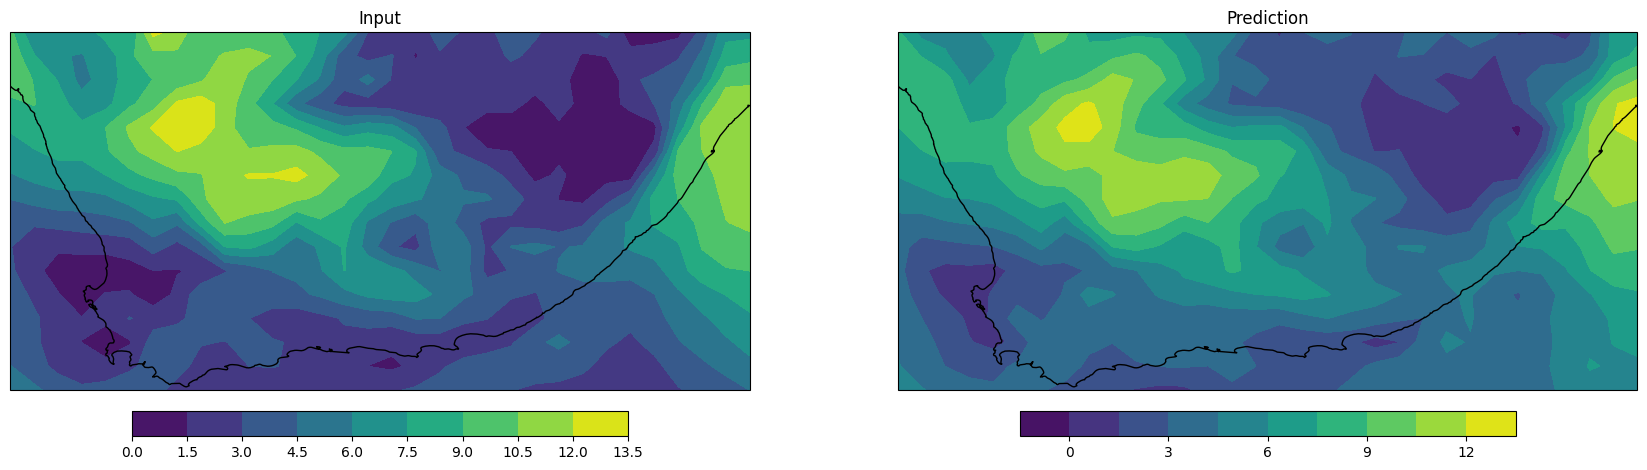

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axs:
    ax.set_extent([ds.longitude.min().item(), ds.longitude.max().item(), ds.latitude.min().item(), ds.latitude.max().item()], crs=ccrs.PlateCarree())
    ax.coastlines()

axs[0].set_title('Input')
axs[1].set_title('Prediction')

seed = 0

feat = axs[0].contourf(ds.longitude, ds.latitude, model_class.y_test[0, 0], levels=10, transform=ccrs.PlateCarree())
tar = axs[1].contourf(ds.longitude, ds.latitude, prediction[0, 0], levels=10, transform=ccrs.PlateCarree())

# Add colorbars for each subplot
cbar_feat = fig.colorbar(feat, ax=axs[0], orientation='horizontal', fraction=0.046, pad=0.04)
cbar_tar = fig.colorbar(tar, ax=axs[1], orientation='horizontal', fraction=0.046, pad=0.04)

plt.show()

In [30]:
ar_prediction = model_class.autoregressive_predict(model_class.X_test[0:1], model_class.F_test[0:1], steps_)

ar_prediction.shape

torch.Size([1, 3, 16, 32]) torch.Size([1, 1, 16, 32])
torch.Size([1, 3, 16, 32]) torch.Size([1, 1, 16, 32])
torch.Size([1, 3, 16, 32]) torch.Size([1, 1, 16, 32])
torch.Size([1, 3, 16, 32]) torch.Size([1, 1, 16, 32])
torch.Size([1, 3, 16, 32]) torch.Size([1, 1, 16, 32])
torch.Size([1, 3, 16, 32]) torch.Size([1, 1, 16, 32])
torch.Size([1, 3, 16, 32]) torch.Size([1, 1, 16, 32])
torch.Size([1, 3, 16, 32]) torch.Size([1, 1, 16, 32])
torch.Size([1, 3, 16, 32]) torch.Size([1, 1, 16, 32])
torch.Size([1, 3, 16, 32]) torch.Size([1, 1, 16, 32])


(10, 16, 32)

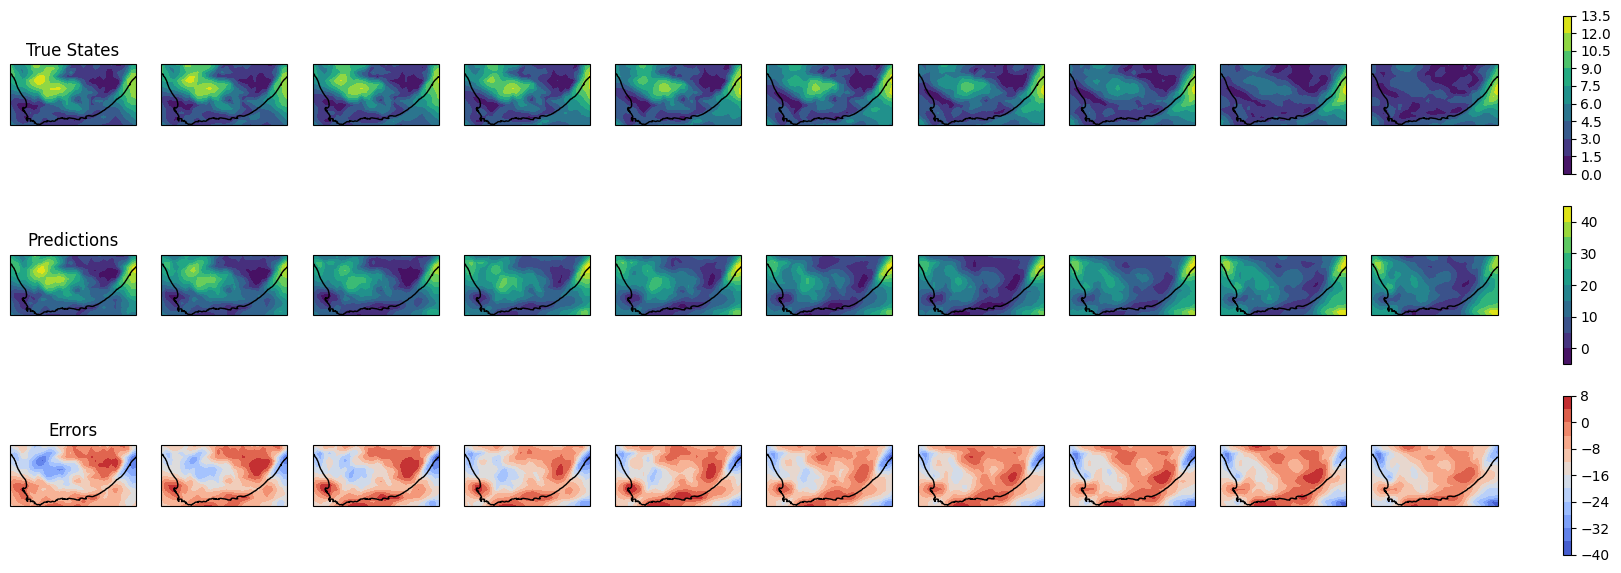

In [31]:
fig, axs = plt.subplots(3, steps_, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

# Set titles for each row
titles_top = 'True States'
titles_middle = 'Predictions'
titles_bottom = 'Errors'

# Add coastlines and titles
for i, ax in enumerate(axs.flatten()):
    ax.coastlines()

axs[0, 0].set_title(titles_top, fontsize=12)
axs[1, 0].set_title(titles_middle, fontsize=12)
axs[2, 0].set_title(titles_bottom, fontsize=12)

for i in range(steps_):
    feat = axs[0, i].contourf(ds.longitude, ds.latitude, model_class.y_test[0, i], levels=10, transform=ccrs.PlateCarree())
    tar = axs[1, i].contourf(ds.longitude, ds.latitude, ar_prediction[i], levels=10, transform=ccrs.PlateCarree())
    err = axs[2, i].contourf(ds.longitude, ds.latitude, model_class.y_test[0, i] - ar_prediction[i], levels=10, transform=ccrs.PlateCarree(), cmap='coolwarm')

cbar_feat = fig.colorbar(feat, ax=axs[0, :], orientation='vertical', fraction=0.046, pad=0.04)
cbar_tar = fig.colorbar(tar, ax=axs[1, :], orientation='vertical', fraction=0.046, pad=0.04)
cbar_err = fig.colorbar(err, ax=axs[2, :], orientation='vertical', fraction=0.046, pad=0.04)

plt.show()